In [1]:
%load_ext autoreload
%autoreload 2
'''
Example of how to use the library for learning using the PILCO learner on the cartpole task
'''
# pylint: disable=C0103
import atexit
import sys
import os
import numpy as np
import kusanagi.ghost.regression as kreg

from kusanagi import utils
from kusanagi.shell.cartpole import default_params
from kusanagi.ghost.learners.PILCO import PILCO, MC_PILCO
from kusanagi.ghost.control import NNPolicy
from kusanagi.utils import plot_results

#np.random.seed(31337)
np.set_printoptions(linewidth=500)

In [2]:
# setup output directory
utils.set_output_dir(os.path.join(utils.get_output_dir(), 'cartpole'))

use_bnn = True
J = 4                                                       # number of random initial trials
N = 100                                                     #learning iterations
pilco_config = default_params()
# initialize learner params for PILCO
pilco_config['params']['use_empirical_x0'] = True
pilco_config['params']['realtime'] = False
pilco_config['params']['H'] = 4.0
pilco_config['params']['plant']['dt'] = 0.1
pilco_config['params']['plant']['params']['l'] = .6
pilco_config['params']['cost']['pendulum_length'] = .6

# create copy of params for MC-PILCO
mcpilco_config = pilco_config.copy()
mcpilco_config['params']['min_method'] = 'ADAM'
mcpilco_config['params']['learning_rate'] = 1e-4
mcpilco_config['params']['max_evals'] = 1000
mcpilco_config['params']['clip'] = 100.0
mcpilco_config['n_samples'] = 25
mcpilco_config['dynmodel_class'] = kreg.BNN
mcpilco_config['policy_class'] = NNPolicy

# init learners
pilco = PILCO(**pilco_config)
mcpilco = MC_PILCO(**mcpilco_config)
mcpilco.resample = False

# share experience and policy between the two learners
mcpilco.experience = pilco.experience
mcpilco.policy = pilco.policy

# gather data with random trials on the pilco learner
for i in range(J):
    pilco.plant.reset_state()
    pilco.apply_controller(random_controls=True)
#pilco.plant.reset_state()
#pilco.apply_controller()

[2017-05-18 19:35:33.898601] RBFPolicy_sat > Initializing parameters
[2017-05-18 19:35:34.001235] RBFPolicy_sat > Initialising expression graph for full GP training loss function
[2017-05-18 19:35:34.292207] RBFPolicy_sat > Initialising expression graph for prediction
[2017-05-18 19:35:34.323627] RBFPolicy_sat > Compiling mean and variance of prediction
[2017-05-18 19:35:39.684281] RBFPolicy_sat > Done compiling
[2017-05-18 19:35:39.751395] Experience > Initialising new experience dataset
[2017-05-18 19:35:39.754646] PILCO > Initialising new PILCO learner
<class 'kusanagi.ghost.control.control_.NNPolicy'> True
[2017-05-18 19:35:39.759472] Experience > Initialising new experience dataset
[2017-05-18 19:35:39.760206] MC_PILCO > Initialising new MC_PILCO learner
[2017-05-18 19:35:39.762405] Cartpole > Reset to inital state
[2017-05-18 19:35:39.763642] PILCO > Compiling cost function
[2017-05-18 19:35:39.765446] PILCO > Cost parameters: {'target': [0, 0, 0, 3.141592653589793], 'width': 0.2

In [3]:
pilco.train_dynamics()

[2017-05-18 19:35:41.997488] PILCO > Training dynamics model
[2017-05-18 19:35:42.000615] GP_UI > Unable to load state from /home/thalassa/gamboa/.kusanagi/output/cartpole/PILCO_GP_UI_6_4_Cartpole_RBFPolicy_sat_dynamics.zip
[2017-05-18 19:35:42.003773] GP_UI > Initialising parameters
[2017-05-18 19:35:42.005966] PILCO > Dataset size:: Inputs: [ (160, 6) ], Targets: [ (160, 4) ]  
[2017-05-18 19:35:42.007345] GP_UI > Initialising expression graph for full GP training loss function
[2017-05-18 19:35:42.318634] GP_UI > Compiling full GP training loss function
[2017-05-18 19:35:43.078537] GP_UI > Compiling gradient of full GP training loss function
[2017-05-18 19:35:54.536280] GP_UI > Current hyperparameters:
[array([[ 0.83455907,  0.23501293,  0.9127485 , -1.12629756, -1.26765415,  1.13171887, -2.07647566, -4.37906075],
       [ 0.83455907,  0.23501293,  0.9127485 , -1.12629756, -1.26765415,  1.13171887, -0.76789865, -3.07048374],
       [ 0.83455907,  0.23501293,  0.9127485 , -1.12629756

In [4]:
mcpilco.train_dynamics(max_episodes=4)

[2017-05-18 19:35:55.748506] MC_PILCO > Training dynamics model
[2017-05-18 19:35:55.750764] BNN > Unable to load state from /home/thalassa/gamboa/.kusanagi/output/cartpole/MC_PILCO_BNN_6_4_Cartpole_NNPolicy_dynamics.zip
[2017-05-18 19:35:55.755127] MC_PILCO > Dataset size:: Inputs: [ (160, 6) ], Targets: [ (160, 4) ]  
[2017-05-18 19:35:55.758488] BNN > Building network
InputLayer {'shape': (None, 6), 'name': 'BNN_input'}
DenseLayer {'num_units': 200, 'nonlinearity': <function tanh at 0x7f65b107fa60>, 'name': 'BNN_fc0'}
DropoutLayer {'p': 0.1, 'rescale': False, 'name': 'BNN_drop0', 'dropout_samples': array(25, dtype=int32)}
DenseLayer {'num_units': 200, 'nonlinearity': <function tanh at 0x7f65b107fa60>, 'name': 'BNN_fc1'}
DropoutLayer {'p': 0.1, 'rescale': False, 'name': 'BNN_drop1', 'dropout_samples': array(25, dtype=int32)}
DenseLayer {'num_units': 4, 'nonlinearity': <function linear at 0x7f65b107fea0>, 'name': 'BNN_output'}
[2017-05-18 19:35:55.771369] BNN > Initialising loss funct

[2017-05-18 19:36:29.426470] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 19:36:30.272101] MC_PILCO > Compiling trajectory rollout function
[2017-05-18 19:36:34.427738] MC_PILCO > Done compiling.


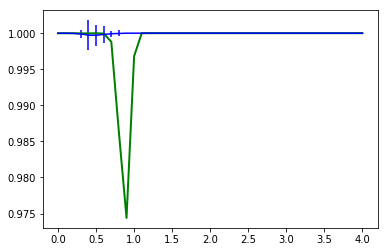

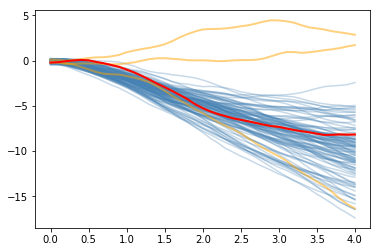

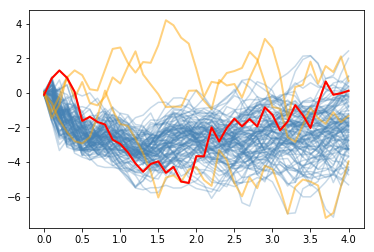

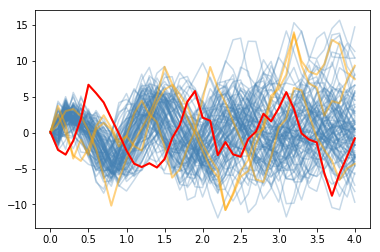

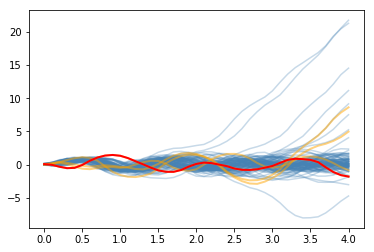

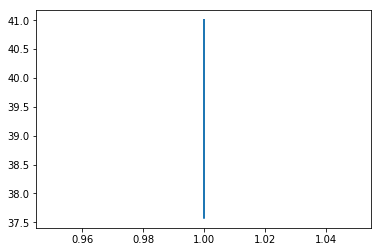

/localdata/juan/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [5]:
mcpilco.resample = False
mcpilco.rollout_fn = None
mcpilco.set_n_samples(100)
plot_results(mcpilco,plot_samples=True)

[2017-05-18 19:36:36.778863] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 19:36:37.396847] MC_PILCO > Compiling trajectory rollout function
[2017-05-18 19:36:42.030215] MC_PILCO > Done compiling.


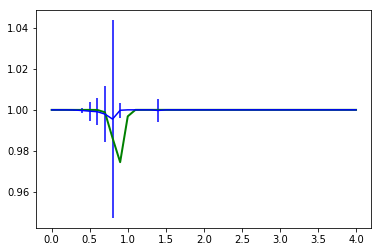

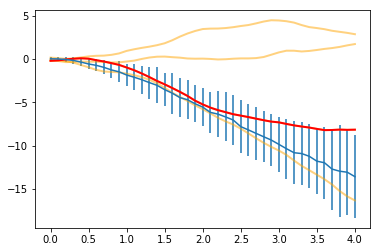

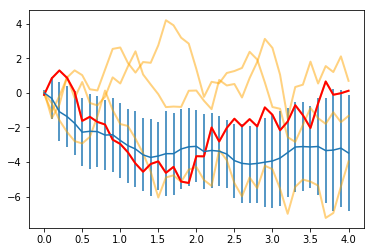

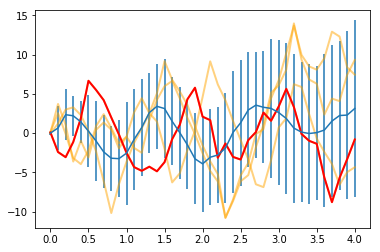

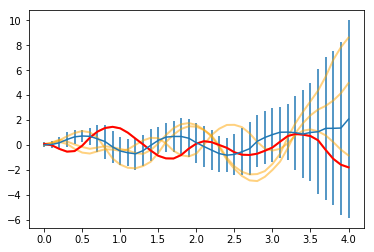

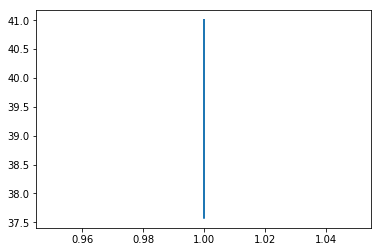

/localdata/juan/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [6]:
mcpilco.resample = True
mcpilco.rollout_fn = None
mcpilco.set_n_samples(100)
plot_results(mcpilco,plot_samples=False)

[2017-05-18 19:36:43.041400] PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 19:36:44.618222] PILCO > Compiling belief state propagation
[2017-05-18 19:36:54.598849] PILCO > Done compiling.
[2017-05-18 19:36:55.080129] plot_results > Predicted value: [40.997826]


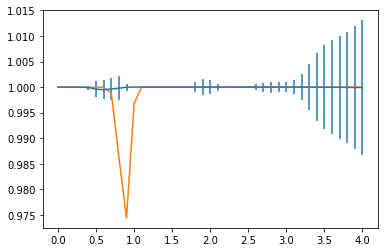

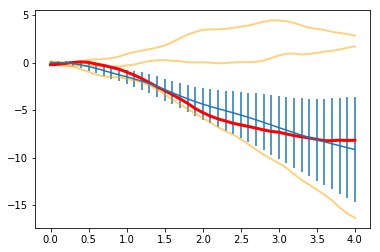

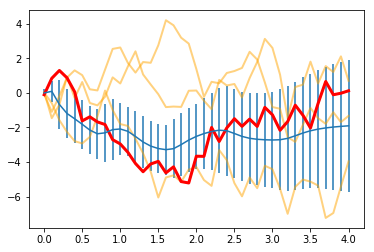

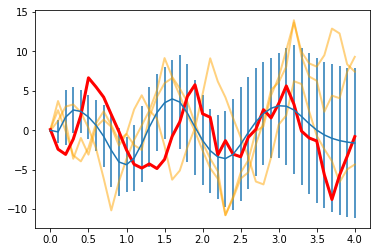

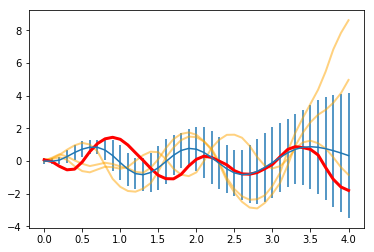

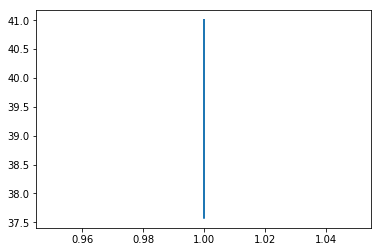

/localdata/juan/miniconda3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


In [ ]:
plot_results(pilco)

In [ ]:
#resample = True
#n_samples = 25
#mcpilco.learning_rate = 1e-4
#if mcpilco.trajectory_samples.get_value() != n_samples or mcpilco.resample != resample:
#    mcpilco.resample = resample
#    mcpilco.set_n_samples(n_samples)
#    mcpilco.rollout_fn = None
#    mcpilco.train_fn = None
mcpilco.set_n_samples(25)
mcpilco.learning_rate = 1e-4
# train
mcpilco.train_policy()
# apply controller
mcpilco.plant.reset_state()
mcpilco.apply_controller()

[2017-05-18 19:36:55.981633] MC_PILCO > Training policy parameters [Iteration 1]
[2017-05-18 19:36:56.033159] MC_PILCO > Initial value estimate [39.998437]
[2017-05-18 19:36:56.034188] MC_PILCO > Using ADAM optimizer
[2017-05-18 19:36:56.034997] MC_PILCO > Computing symbolic expression graph for belief state propagation
[2017-05-18 19:36:57.000670] MC_PILCO > Compiling optimizer
[2017-05-18 19:36:57.001795] MC_PILCO > Computing symbolic expression for policy gradients
[2017-05-18 19:37:39.364181] MC_PILCO > Done compiling.
[2017-05-18 19:40:48.185563] MC_PILCO > Current value: 3.999845E+01, Total evaluations: 676, gm: [0.10906770936184637, 0.02329887544298638, 0.0073170745964663154], lr: 0.0001000000

In [9]:
#mcpilco.save()